# Data load and processing

In [ ]:
import pandas as pd

url = "https://raw.githubusercontent.com/LearnDataSci/articles/refs/heads/master/Python%20Pandas%20Tutorial%20A%20Complete%20Introduction%20for%20Beginners/IMDB-Movie-Data.csv"
df = pd.read_csv(url)


In [2]:
df.head()

,Rank,Title,Genre,Description,Director,Actors,Year,Runtime (Minutes),Rating,Votes,Revenue (Millions),Metascore
0,1,Guardians of the Galaxy,"Action,Adventure,Sci-Fi",A group of intergalactic criminals are forced ...,James Gunn,"Chris Pratt, Vin Diesel, Bradley Cooper, Zoe S...",2014,121,8.1,757074,333.13,76.0
1,2,Prometheus,"Adventure,Mystery,Sci-Fi","Following clues to the origin of mankind, a te...",Ridley Scott,"Noomi Rapace, Logan Marshall-Green, Michael Fa...",2012,124,7.0,485820,126.46,65.0
2,3,Split,"Horror,Thriller",Three girls are kidnapped by a man with a diag...,M. Night Shyamalan,"James McAvoy, Anya Taylor-Joy, Haley Lu Richar...",2016,117,7.3,157606,138.12,62.0
3,4,Sing,"Animation,Comedy,Family","In a city of humanoid animals, a hustling thea...",Christophe Lourdelet,"Matthew McConaughey,Reese Witherspoon, Seth Ma...",2016,108,7.2,60545,270.32,59.0
4,5,Suicide Squad,"Action,Adventure,Fantasy",A secret government agency recruits some of th...,David Ayer,"Will Smith, Jared Leto, Margot Robbie, Viola D...",2016,123,6.2,393727,325.02,40.0


In [3]:

print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Rank                1000 non-null   int64  
 1   Title               1000 non-null   object 
 2   Genre               1000 non-null   object 
 3   Description         1000 non-null   object 
 4   Director            1000 non-null   object 
 5   Actors              1000 non-null   object 
 6   Year                1000 non-null   int64  
 7   Runtime (Minutes)   1000 non-null   int64  
 8   Rating              1000 non-null   float64
 9   Votes               1000 non-null   int64  
 10  Revenue (Millions)  872 non-null    float64
 11  Metascore           936 non-null    float64
dtypes: float64(3), int64(4), object(5)
memory usage: 93.9+ KB
None


In [ ]:
import re

def clean_text(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = text.lower().strip()
    return text

df['Description'] = df['Description'].apply(clean_text)


In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel


if 'Description' not in df.columns:
    raise ValueError("The DataFrame must contain a 'Description' column.")

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModel.from_pretrained('bert-base-uncased')
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

inputs = tokenizer(df['Description'].tolist(), padding=True, truncation=True,
                   return_tensors="pt", max_length=512)

inputs = {key: val.to(device) for key, val in inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()  

embeddings_list = embeddings.tolist()

df['Embeddings'] = embeddings_list

output_file = 'IMDB_Movie_Data_with_Embeddings.csv'
df.to_csv(output_file, index=False)

print(f"Embeddings have been added to the DataFrame and saved to '{output_file}'.")


Embeddings have been added to the DataFrame and saved to 'IMDB_Movie_Data_with_Embeddings.csv'.


# Calculate cosine similarity between the embeddings

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

embeddings_matrix = np.vstack(df['Embeddings'].values)

similarity_matrix = cosine_similarity(embeddings_matrix)

similarity_score = similarity_matrix[0][1]


In [ ]:
threshold = 0.93 
similar_movies = []

for i in range(len(similarity_matrix)):
    similar_movies.append([df['Title'][j] for j in range(len(similarity_matrix[i])) if similarity_matrix[i][j] > threshold and i != j])

df['Similar_Movies'] = similar_movies


In [ ]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

df['Genre'] = df['Genre'].apply(lambda x: x if isinstance(x, list) else [i.strip() for i in x.split(',')])

mlb = MultiLabelBinarizer()
Y_genre = mlb.fit_transform(df['Genre'])

print("Genres Binarized:", mlb.classes_)


Genres Binarized: ['Action' 'Adventure' 'Animation' 'Biography' 'Comedy' 'Crime' 'Drama'
 'Family' 'Fantasy' 'History' 'Horror' 'Music' 'Musical' 'Mystery'
 'Romance' 'Sci-Fi' 'Sport' 'Thriller' 'War' 'Western']


In [9]:
df.head()

,Rank,Title,Genre,Description,Director,Actors,Year,Runtime (Minutes),Rating,Votes,Revenue (Millions),Metascore,Embeddings,Similar_Movies
0,1,Guardians of the Galaxy,"[Action, Adventure, Sci-Fi]",a group of intergalactic criminals are forced ...,James Gunn,"Chris Pratt, Vin Diesel, Bradley Cooper, Zoe S...",2014,121,8.1,757074,333.13,76.0,"[-0.47883322834968567, 0.01290871575474739, -0...","[Suicide Squad, Interstellar, Star Wars: Episo..."
1,2,Prometheus,"[Adventure, Mystery, Sci-Fi]",following clues to the origin of mankind a tea...,Ridley Scott,"Noomi Rapace, Logan Marshall-Green, Michael Fa...",2012,124,7.0,485820,126.46,65.0,"[-0.345752477645874, 0.2648966610431671, -0.05...",[Godzilla]
2,3,Split,"[Horror, Thriller]",three girls are kidnapped by a man with a diag...,M. Night Shyamalan,"James McAvoy, Anya Taylor-Joy, Haley Lu Richar...",2016,117,7.3,157606,138.12,62.0,"[-0.06884898990392685, 0.028244566172361374, 0...","[Midnight Special, Horrible Bosses, Custody]"
3,4,Sing,"[Animation, Comedy, Family]",in a city of humanoid animals a hustling theat...,Christophe Lourdelet,"Matthew McConaughey,Reese Witherspoon, Seth Ma...",2016,108,7.2,60545,270.32,59.0,"[-0.2047910988330841, -0.006248855032026768, 0...","[Interstellar, Avatar, San Andreas, Pan's Laby..."
4,5,Suicide Squad,"[Action, Adventure, Fantasy]",a secret government agency recruits some of th...,David Ayer,"Will Smith, Jared Leto, Margot Robbie, Viola D...",2016,123,6.2,393727,325.02,40.0,"[-0.5413061380386353, -0.3579096794128418, 0.1...","[Guardians of the Galaxy, Star Wars: Episode V..."


# Label Encoding for Genre

In [10]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

df['Genre'] = df['Genre'].apply(lambda x: x if isinstance(x, list) else [i.strip() for i in x.split(',')])
Y_genre = mlb.fit_transform(df['Genre'])

genre_df = pd.DataFrame(Y_genre, columns=mlb.classes_, index=df.index)
df = pd.concat([df, genre_df], axis=1)

In [11]:
df.head()

,Rank,Title,Genre,Description,Director,Actors,Year,Runtime (Minutes),Rating,Votes,...,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
0,1,Guardians of the Galaxy,"[Action, Adventure, Sci-Fi]",a group of intergalactic criminals are forced ...,James Gunn,"Chris Pratt, Vin Diesel, Bradley Cooper, Zoe S...",2014,121,8.1,757074,...,0,0,0,0,0,1,0,0,0,0
1,2,Prometheus,"[Adventure, Mystery, Sci-Fi]",following clues to the origin of mankind a tea...,Ridley Scott,"Noomi Rapace, Logan Marshall-Green, Michael Fa...",2012,124,7.0,485820,...,0,0,0,1,0,1,0,0,0,0
2,3,Split,"[Horror, Thriller]",three girls are kidnapped by a man with a diag...,M. Night Shyamalan,"James McAvoy, Anya Taylor-Joy, Haley Lu Richar...",2016,117,7.3,157606,...,1,0,0,0,0,0,0,1,0,0
3,4,Sing,"[Animation, Comedy, Family]",in a city of humanoid animals a hustling theat...,Christophe Lourdelet,"Matthew McConaughey,Reese Witherspoon, Seth Ma...",2016,108,7.2,60545,...,0,0,0,0,0,0,0,0,0,0
4,5,Suicide Squad,"[Action, Adventure, Fantasy]",a secret government agency recruits some of th...,David Ayer,"Will Smith, Jared Leto, Margot Robbie, Viola D...",2016,123,6.2,393727,...,0,0,0,0,0,0,0,0,0,0


In [12]:
df.to_csv('movies_with_genres.csv', index=False)

# Baseline Model

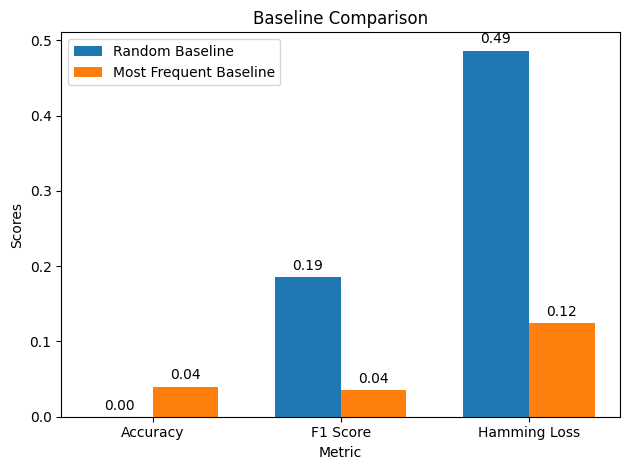

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, hamming_loss
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

X = np.stack(df['Embeddings'].values)  
mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(df['Genre'])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

dummy_random = DummyClassifier(strategy="uniform")
dummy_random.fit(X_train, Y_train)
random_pred = dummy_random.predict(X_test)

dummy_freq = DummyClassifier(strategy="most_frequent")
dummy_freq.fit(X_train, Y_train)
freq_pred = dummy_freq.predict(X_test)

random_accuracy = accuracy_score(Y_test, random_pred)
random_f1 = f1_score(Y_test, random_pred, average='macro')
random_hamming = hamming_loss(Y_test, random_pred)

freq_accuracy = accuracy_score(Y_test, freq_pred)
freq_f1 = f1_score(Y_test, freq_pred, average='macro')
freq_hamming = hamming_loss(Y_test, freq_pred)

categories = ['Accuracy', 'F1 Score', 'Hamming Loss']
random_baseline_scores = [random_accuracy, random_f1, random_hamming]
most_frequent_baseline_scores = [freq_accuracy, freq_f1, freq_hamming]

fig, ax = plt.subplots()
index = range(len(categories))
bar_width = 0.35

rects1 = ax.bar(index, random_baseline_scores, bar_width, label='Random Baseline')
rects2 = ax.bar([p + bar_width for p in index], most_frequent_baseline_scores, bar_width, label='Most Frequent Baseline')

ax.set_xlabel('Metric')
ax.set_ylabel('Scores')
ax.set_title('Baseline Comparison')
ax.set_xticks([p + bar_width / 2 for p in index])
ax.set_xticklabels(categories)
ax.legend()

def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)

plt.tight_layout()
plt.show()
